<a href="https://colab.research.google.com/github/wkt84/emt-python/blob/master/notebook/Python12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom  # pydicomのインストール
import pydicom

     |████████████████████████████████| 35.1MB 117kB/s 


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
cd '/gdrive/My Drive/python/DICOMdata/'

/gdrive/My Drive/python/DICOMdata


In [0]:
# よく使うパッケージと表示の設定

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', grid='False')

In [5]:
rtss = pydicom.dcmread('RS.002445.dcm')

structures = {}
for roi in rtss.StructureSetROISequence:
    structures[roi.ROINumber] = roi.ROIName
    print('ROI number: ', roi.ROINumber, 'ROI name: ', roi.ROIName)

ROI number:  1 ROI name:  RT LENS
ROI number:  2 ROI name:  SPINAL_CORD
ROI number:  3 ROI name:  CORD+5MM
ROI number:  4 ROI name:  LT_PAROTID
ROI number:  5 ROI name:  MANDIBLE
ROI number:  7 ROI name:  RETROPHARYNGEAL
ROI number:  9 ROI name:  RT OPTIC NERVE
ROI number:  10 ROI name:  RT SMG
ROI number:  11 ROI name:  CTV56
ROI number:  12 ROI name:  BRAIN
ROI number:  13 ROI name:  LT LENS
ROI number:  14 ROI name:  BRAINSTEM
ROI number:  15 ROI name:  GTV70
ROI number:  16 ROI name:  LT OPTIC NERVE
ROI number:  17 ROI name:  CTV63
ROI number:  18 ROI name:  PTV70
ROI number:  19 ROI name:  PTV63
ROI number:  20 ROI name:  RT EYE
ROI number:  22 ROI name:  PTV56
ROI number:  23 ROI name:  CTV70
ROI number:  25 ROI name:  LT EYE
ROI number:  26 ROI name:  RT_PAROTID
ROI number:  29 ROI name:  LARYNX
ROI number:  30 ROI name:  BODY
ROI number:  31 ROI name:  LEFT LUNG
ROI number:  32 ROI name:  RT LUNG
ROI number:  36 ROI name:  LT COCHLEA
ROI number:  37 ROI name:  RT COCHLEA


In [0]:
contours = {}

# Structureごとにループ
for contour in rtss.ROIContourSequence:
    structure = structures[contour.ReferencedROINumber]  # 輪郭名を辞書より取得
    contours[structure] = {}  # 輪郭名をkeyとして空辞書を作成

    points = {}
    for c in contour.ContourSequence:
        # 閉じた輪郭以外（POIなど）を無視
        if c.ContourGeometricType != 'CLOSED_PLANAR':
            continue
        contour_data = c.ContourData
        x = [float(x) for x in contour_data[::3]]
        y = [float(y) for y in contour_data[1::3]]
        z = float(contour_data[2])
        xy = list(zip(x, y))  # x座標とy座標を1組のリストへ
        xy.append(xy[0])  # 計算のため最後の座標点を1つめの座標点で追加

        if z not in points:
            points[z] = []  # 初めてのz座標に対しては空リスト作成
        points[z].append(xy)  # リストに輪郭を追加
    
    # pointsというkeyにz座標に対する輪郭点を格納した辞書を追加
    contours[structure]['points'] = points

In [7]:
PTV70_points = contours['PTV70']['points']

# z座標とそのz座標にある輪郭の数を表示
for z, points in PTV70_points.items():
    print(z, len(points))

-67.5 1
-65.0 1
-62.5 1
-60.0 1
-57.5 1
-55.0 1
-52.5 1
-50.0 1
-47.5 1
-45.0 1
-42.5 1
-40.0 1
-37.5 1
-35.0 1
-32.5 1
-30.0 1
-27.5 1
-25.0 1
-22.5 1
-20.0 1
-17.5 1
-15.0 2
-12.5 2
-10.0 2
-7.5 2
-5.0 2
-2.5 2
0.0 2
2.5 1
5.0 1
7.5 1
10.0 1
12.5 1
15.0 1
17.5 1
20.0 1
22.5 1
25.0 1
27.5 1
30.0 1
32.5 1
35.0 1
37.5 1
40.0 1
42.5 1
45.0 1
47.5 1
50.0 1
52.5 1
55.0 1


In [8]:
s = 0
for points in PTV70_points.values():
    # 同一z座標内に複数輪郭がある場合の繰り返し
    for point in points:
        for i in range(len(point)-1):
            s += (point[i][0] * point[i+1][1] - point[i+1][0] * point[i][1]) / 2

thickness = 2.5
v = s * thickness / 1000
print('volume:', v, 'cm3')

volume: 236.90448474999994 cm3


In [0]:
# まずPathを作る
from matplotlib.path import Path

for contour in rtss.ROIContourSequence:
    structure = structures[contour.ReferencedROINumber]  # 輪郭名を取得
    # 先ほど抽出した座標点を取得
    points = contours[structure]['points']
    # Pathを作成
    paths = {}
    for z, p in points.items():
        if len(p) > 1:  # 同じz座標に輪郭が2つ以上ある場合
            for i, c in enumerate(p):
                # Path生成用のcodeを作成
                codes = np.ones(len(c)) * Path.LINETO
                codes[0] = Path.MOVETO  # 輪郭点のはじめはMOVETO
                codes[-1] = Path.CLOSEPOLY  # 輪郭点の終わりはCLOSEPOLY
                if i==0:  # 最初の輪郭
                    all_paths = c
                    all_codes = codes
                else:  # 2つ目以降の輪郭を合体
                    all_paths = np.concatenate((all_paths, c))
                    all_codes = np.concatenate((all_codes, codes))
        else:  # 同じz座標に輪郭が1つの場合
            all_paths = p[0]
            all_codes = np.ones(len(p[0])) * Path.LINETO
            all_codes[0] = Path.MOVETO
            all_codes[-1] = Path.CLOSEPOLY

        path = Path(all_paths, all_codes)
        paths[z] = path
    # pathsというKeyにz座標に対するPathを格納した辞書を追加
    contours[structure]['paths'] = paths

In [0]:
# PTV70を例に
z = 0
PTV70_paths = contours['PTV70']['paths']
path_z = PTV70_paths[z] # z = 0のスライスのPathを取り出し

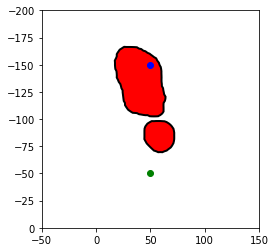

In [11]:
import matplotlib.patches as patches

fig = plt.figure()
ax = fig.add_subplot(111)
patch = patches.PathPatch(path_z, fc='red', lw=2)
ax.add_patch(patch)
ax.plot(50, -150, 'bo')
ax.plot(50, -50, 'go')
ax.set_xlim(-50,150)
ax.set_ylim(0,-200)
ax.set_aspect('equal')

In [12]:
path_z.contains_points([[50,-150], [50, -50]])

array([ True, False])

In [13]:
x = [1,2,3,4,5]
y = [0,1,2]
# リスト内包表記を使う
grid = [[i, j] for j in y for i in x]
print(grid)

[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2]]


In [14]:
PTV70_x = [p[0] for points in PTV70_points.values() for point in points for p in point]
PTV70_y = [p[1] for points in PTV70_points.values() for point in points for p in point]
x_max = max(PTV70_x)
x_min = min(PTV70_x)
y_max = max(PTV70_y)
y_min = min(PTV70_y)
print(x_max, x_min, y_max, y_min)

73.73 -0.59 -64.51 -166.45


In [0]:
x = np.arange(np.floor(x_min), np.ceil(x_max)+1, 1)
y = np.arange(np.floor(y_min), np.ceil(y_max)+1, 1)
grid = [[i, j] for j in y for i in x]

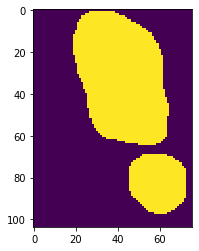

In [16]:
mask = path_z.contains_points(grid).reshape(y.size, x.size)
plt.imshow(mask)

In [17]:
num_of_pix = 0

for path in PTV70_paths.values():
    mask = path.contains_points(grid)
    # True=1, False=0なので、sum()でTrueの個数をカウント
    num_of_pix += mask.sum()

area_of_pix = 1 * 1
thickness = 2.5  # mm
v = num_of_pix * area_of_pix * thickness / 1000  # mm3 => cm3
print('volume:', v, 'cm3')

volume: 237.09 cm3


In [22]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
ax = fig.add_subplot(111)
plt.close()

def update(frame):
    if frame != 0:
        ax.cla()
    z = 55.0 - frame*2.5
    mask = PTV70_paths[z].contains_points(grid).reshape(y.size, x.size)
    ax.imshow(mask)
  
    ax.set_aspect('equal')
    ax.set_title('z = {0} mm'.format(z))

anim = animation.FuncAnimation(fig, update, interval=30, frames=len(PTV70_paths))
HTML(anim.to_jshtml())

50